#<font color="red">Install Downloader</font>

In [8]:
!pip install gdown

#<font color="red">Download Dataset</font>

In [11]:
!gdown https://github.com/syahirulfaiz/K-means_Clustering_on_Multiple_Documents/raw/main/animals
!gdown https://github.com/syahirulfaiz/K-means_Clustering_on_Multiple_Documents/raw/main/countries
!gdown https://github.com/syahirulfaiz/K-means_Clustering_on_Multiple_Documents/raw/main/fruits
!gdown https://github.com/syahirulfaiz/K-means_Clustering_on_Multiple_Documents/raw/main/veggies

Downloading...
From: https://github.com/syahirulfaiz/K-means_Clustering_on_Multiple_Documents/raw/main/animals
To: /content/animals
130kB [00:00, 6.71MB/s]        
Downloading...
From: https://github.com/syahirulfaiz/K-means_Clustering_on_Multiple_Documents/raw/main/countries
To: /content/countries
416kB [00:00, 9.77MB/s]       
Downloading...
From: https://github.com/syahirulfaiz/K-means_Clustering_on_Multiple_Documents/raw/main/fruits
To: /content/fruits
151kB [00:00, 6.99MB/s]        
Downloading...
From: https://github.com/syahirulfaiz/K-means_Clustering_on_Multiple_Documents/raw/main/veggies
To: /content/veggies
155kB [00:00, 6.11MB/s]        


#<font color="red">Import Libraries</font>

In [12]:
'''
tested in python 3.x

[INFO] default max_iteration = 50. But the user are allowed to change this

'''

import matplotlib.pyplot as plt
import numpy as np

#for control flow input from the user
CHOICE = 0


#<font color="red">Load Data Method</font>

In [13]:
#Load Data function for load_all_data():
def load_data(fname):
    label = []
    features = []
    with open(fname) as F:
        i=0
        for line in F:
            p = line.strip().split(" ")
            x = np.zeros(len(p)-1)
            label.append(fname)
            for i in range(1,len(p)):
                x[i-1] = float(p[i])
            features.append(x)
    return np.asarray(label), np.asarray(features)


In [14]:
#Load All 4 Data from 4 Categories
def load_all_data():
    label1,features1=load_data('animals')
    label2,features2=load_data('countries')
    label3,features3=load_data('fruits')
    label4,features4=load_data('veggies')

    label=np.append(np.append(np.append(label1,label2,axis=0),label3,axis=0),label4,axis=0)
    features=np.append(np.append(np.append(features1,features2,axis=0),features3,axis=0),features4,axis=0)

    return label, features

#<font color="red">Euclidean vs Manhattan vs Cosine Distance</font>

In [21]:
#Euclidean Distance : as objective function/distance measure, for question number 1 - 3
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))


#Manhattan Distance  : as objective function/distance measure, for question number 4 - 5
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

#Cosine Similarity : as objective function/distance measure, for question number 6
def cosine_similarity(x1, x2):
    np.warnings.simplefilter("ignore")
    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))


###<font color="red">L2 Regularisation</font>

In [18]:
#L2_normalise the 300 feature values for each instances (question number 3 & 5)
def L2_normalise(x):
    for i in range(0,len(x)):
        norm = np.sqrt(np.sum(x[i,:] * x[i,:]))
        x[i,:] = x[i,:] / norm
    return x

#<font color="red">Confusion Matrix</font>

In [19]:
#factorial func for combination(x1,x2) function below
def factorial(x1):
    num=1
    for i in range(1,x1+1,1):num=num*i
    return num


#combination func for cooccurrence matrix
def combination(x1,x2):
    if(x1<x2): num = 0
    else: num = factorial(x1)/(factorial((x1-x2)) * factorial(x2))
    return num


#create cooccurence matrix for the categories/labels in clusters
def get_cooccurence_matrix(cluster, label):
    distinct_cluster=sorted(list(set(cluster)))
    distinct_label=sorted(list(set(label)))

    cooccurrence_matrix=np.zeros((len(distinct_label),len(distinct_cluster)), dtype=int)
    i=0
    for cluster_idx in range(len(cluster)):
        for label_idx in range(len(label)):
            i=i+1
            if cluster_idx==label_idx :
                cooccurrence_matrix[distinct_label.index(label[label_idx])][distinct_cluster.index(cluster[cluster_idx])]=cooccurrence_matrix[distinct_label.index(label[label_idx])][distinct_cluster.index(cluster[cluster_idx])] + 1
    return np.asarray(cooccurrence_matrix)

#ignore RuntimeWarning
np.seterr(all='ignore')
#apply combination func in array
vectorise_combination = np.vectorize(combination)

#get_TP_FP_TN_FN for precision, recall, and f_score
def get_TP_FP_TN_FN(cooccurrence_matrix):
    TP_FP = vectorise_combination(cooccurrence_matrix.sum(0, dtype=int),2).sum()
    TP_FN = vectorise_combination(cooccurrence_matrix.sum(1, dtype=int),2).sum()
    TP = vectorise_combination(cooccurrence_matrix.astype(int), 2).sum()
    FP = TP_FP - TP
    FN = TP_FN - TP
    TN = combination(cooccurrence_matrix.sum(), 2) - TP - FP - FN

    return [TP, FP, TN, FN]

#get_evaluation_measure
def get_evaluation_measure(TP,FP,TN,FN):
    #rand_index = float(TP + TN) / (TP + FP + FN + TN))
    precision = float(TP) / (TP + FP)
    recall = float(TP) / (TP + FN)
    f_score = (2.0 * precision * recall) / (precision + recall)

    return precision, recall, f_score

#<font color="red">KMeans Algorithm</font>

In [22]:
# func for assigning all other instances to closest centroids
def create_clusters(centroids, k, X, distance):
    # Assign the instances to the closest centroids to create clusters
    clusters = [[] for _ in range(k)]
    for idx, instance in enumerate(X):
        centroid_idx = closest_centroid(instance, centroids, distance)
        clusters[centroid_idx].append(idx)
    return clusters


# for calculating the distance measure/objective function of the clustering problem
def closest_centroid(instance, centroids, distance):
    # distance of the current instance to each centroid
    if distance =='manhattan':
        distances = [manhattan_distance(instance, point) for point in centroids]
    elif distance =='cosine':
        distances = [cosine_similarity(instance, point) for point in centroids]
    else:
        distances = [euclidean_distance(instance, point) for point in centroids]
    closest_index = np.argmin(distances)
    return closest_index


# func for computing the new mean/centroid from the clusters
def get_centroids(clusters, k, X, n_features):
    # assign mean value of clusters to centroids
    centroids = np.zeros((k, n_features))
    for cluster_idx, cluster in enumerate(clusters):
        cluster_mean = np.mean(X[cluster], axis=0)
        centroids[cluster_idx] = cluster_mean
    return centroids


# func for checking if converged; no instances have moved among clusters
def is_converged(centroids_old, centroids, k, distance):
    # distances between each old and new centroids, fol all centroids
    if distance == 'manhattan':
        distances = [manhattan_distance(centroids_old[i], centroids[i]) for i in range(k)]
    elif distance == 'cosine' :
        distances = [cosine_similarity(centroids_old[i], centroids[i]) for i in range(k)]
    else:
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(k)]
    return sum(distances) == 0


## assign each instance the label of the predicted cluster
def get_cluster_labels(clusters, n_instances):

    labels = np.empty(n_instances)

    for cluster_idx, cluster in enumerate(clusters):
        for instance_idx in cluster:
            labels[instance_idx] = cluster_idx
    return labels


#KMEANS_predict
def KMEANS_predict(X, k=4, distance='euclidean', normalise=False, max_iteration=50):
    # list for each cluster
    clusters = [[] for _ in range(k)]
    # the centers for each cluster
    centroids = []

    if normalise==True:
        #print('its normalised')
        X=L2_normalise(X)

    n_instances, n_features = X.shape

    # randomly choose some instances as centroids
    random_instance_idxs = np.random.choice(n_instances, k, replace=False)
    centroids = [X[idx] for idx in random_instance_idxs]

    # k-means clustering iteration
    for iteration in range(max_iteration):
        # 1. assign all other instances to closest centroids
        clusters = create_clusters(centroids,k,X,distance)

        # 2. compute the new mean/centroid from the clusters
        centroids_old = centroids
        centroids = get_centroids(clusters, k, X, n_features)

        # 3. break iteration if converged
        if is_converged(centroids_old, centroids, k, distance):
            break

    # Classify instances as the index of their clusters
    return iteration, get_cluster_labels(clusters,n_instances)

#<font color="red">Experiment</font>

##<font color="red">(1).Eucledian Distance</font>

Please choose k-means clustering mode options (1-5) :

(1).Eucledian Distance
(2).L2-normalisation feature, then using Euclidean Distance
(3).Manhattan Distance
(4).L2-normalisation feature, then using Manhattan Distance
(5).Cosine Similarity Distance (a bit long(?) to wait...)
(0).exit()

Your choice:1
k= 1 precision= 0.32485729112610273 recall= 1.0 f_score= 0.49040344692518606 (after 1 iteration)
k= 2 precision= 0.6514047866805411 recall= 1.0 f_score= 0.7889098928796472 (after 6 iteration)
k= 3 precision= 0.83329985940952 recall= 0.9468279324509357 f_score= 0.8864437560089734 (after 7 iteration)
k= 4 precision= 0.8457262716308338 recall= 0.9201277955271565 f_score= 0.8813596371386415 (after 5 iteration)
k= 5 precision= 0.933777700831025 recall= 0.6154153354632588 f_score= 0.7418844566712517 (after 14 iteration)
k= 6 precision= 0.9112217382285833 recall= 0.5012551346417161 f_score= 0.6467427309532573 (after 7 iteration)
k= 7 precision= 0.8378114842903576 recall= 0.44117982656321314 f_

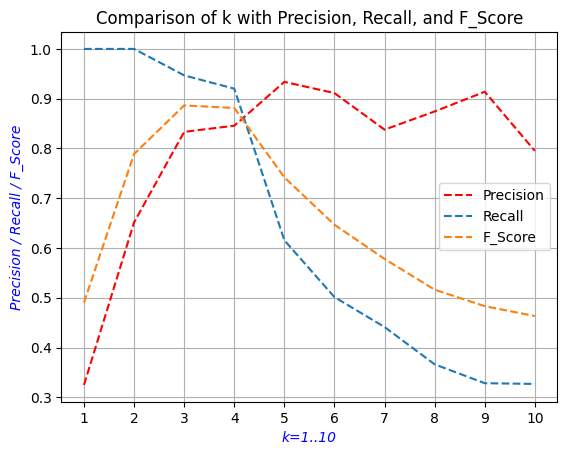

In [25]:
def flow():
    global CHOICE
    CHOICE=int(input('Please choose k-means clustering mode options (1-5) :\n\n(1).Eucledian Distance\n(2).L2-normalisation feature, then using Euclidean Distance\n(3).Manhattan Distance\n(4).L2-normalisation feature, then using Manhattan Distance\n(5).Cosine Similarity Distance (a bit long(?) to wait...)\n(0).exit()\n\nYour choice:'))
    if (CHOICE != 1) & (CHOICE != 2) & (CHOICE != 3) & (CHOICE != 4) & (CHOICE != 5) & (CHOICE != 0) :
        flow()

    label, features=load_all_data()

    precision_vector = []
    recall_vector = []
    f_score_vector = []

    for k in range(1,11):
        if CHOICE == 1: iteration, cluster = KMEANS_predict(features, k, 'eucledian') #Euclidean Distance
        elif CHOICE == 2: iteration, cluster = KMEANS_predict(features, k, 'eucledian', True) #Euclidean Distance with L2 norm
        elif CHOICE == 3: iteration, cluster = KMEANS_predict(features, k, 'manhattan') #Manhattan Distance
        elif CHOICE == 4: iteration, cluster = KMEANS_predict(features, k, 'manhattan', True) #Manhattan Distance with L2 norm
        elif CHOICE == 5: iteration, cluster = KMEANS_predict(features, k, 'cosine') #Cosine Similarity Distance
        elif (CHOICE == 0) : exit()
        cooccurrence_matrix = get_cooccurence_matrix(cluster,label)
        tp, fp, tn, fn = get_TP_FP_TN_FN(cooccurrence_matrix)
        precision, recall, f_score  = get_evaluation_measure(tp,fp,tn,fn)
        print("k=",k,"precision=",precision,"recall=",recall,"f_score=",f_score,"(after",iteration,"iteration)")
        precision_vector.append(precision)
        recall_vector.append(recall)
        f_score_vector.append(f_score)

    precision_vector = np.asarray(precision_vector)
    recall_vector = np.asarray(recall_vector)
    f_score_vector = np.asarray(f_score_vector)

    plt.plot(np.arange(1,11,step=1), precision_vector,"r--",label="Precision")
    plt.plot(np.arange(1,11,step=1), recall_vector,"--", label="Recall")
    plt.plot(np.arange(1,11,step=1), f_score_vector,"--", label="F_Score")
    plt.xticks(np.arange(1,11,step=1))
    plt.xlabel("k=1..10", fontsize=10, color="blue", style="italic")
    plt.ylabel("Precision / Recall / F_Score", fontsize=10, color="blue", style="italic")
    plt.title("Comparison of k with Precision, Recall, and F_Score")
    plt.legend()
    plt.grid(True)
    plt.show()


########################## MAIN PROGRAM #############################

flow()



##<font color="red">(2).L2-normalisation feature, then using Euclidean Distance</font>

Please choose k-means clustering mode options (1-5) :

(1).Eucledian Distance
(2).L2-normalisation feature, then using Euclidean Distance
(3).Manhattan Distance
(4).L2-normalisation feature, then using Manhattan Distance
(5).Cosine Similarity Distance (a bit long(?) to wait...)
(0).exit()

Your choice:2
k= 1 precision= 0.32485729112610273 recall= 1.0 f_score= 0.49040344692518606 (after 1 iteration)
k= 2 precision= 0.6514047866805411 recall= 1.0 f_score= 0.7889098928796472 (after 4 iteration)
k= 3 precision= 0.8342963564299699 recall= 0.9967480602464628 f_score= 0.9083157867373729 (after 8 iteration)
k= 4 precision= 0.693685467443984 recall= 0.5634413509812871 f_score= 0.6218164646623642 (after 11 iteration)
k= 5 precision= 0.9675434999121214 recall= 0.9422067549064355 f_score= 0.9547070555250456 (after 6 iteration)
k= 6 precision= 0.8653417533432393 recall= 0.5316065723413966 f_score= 0.6586089906700594 (after 13 iteration)
k= 7 precision= 0.5549330298520528 recall= 0.3616499315381104 

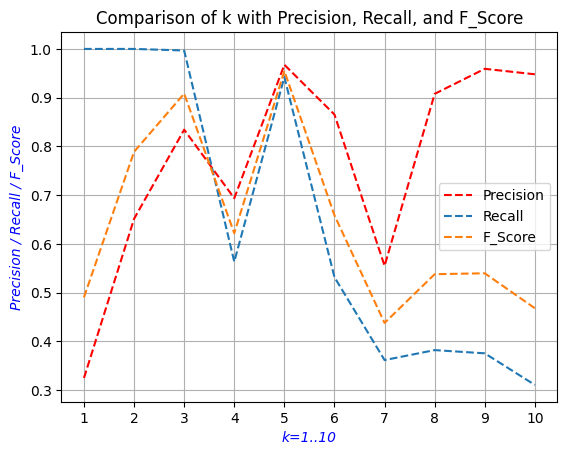

In [26]:
flow()

##<font color="red">(3).Manhattan Distance</font>

Please choose k-means clustering mode options (1-5) :

(1).Eucledian Distance
(2).L2-normalisation feature, then using Euclidean Distance
(3).Manhattan Distance
(4).L2-normalisation feature, then using Manhattan Distance
(5).Cosine Similarity Distance (a bit long(?) to wait...)
(0).exit()

Your choice:3
k= 1 precision= 0.32485729112610273 recall= 1.0 f_score= 0.49040344692518606 (after 1 iteration)
k= 2 precision= 0.6514047866805411 recall= 1.0 f_score= 0.7889098928796472 (after 4 iteration)
k= 3 precision= 0.5519250979268177 recall= 0.6591738931994523 f_score= 0.6008007903905154 (after 5 iteration)
k= 4 precision= 0.9500057464659235 recall= 0.9431766316750342 f_score= 0.9465788720297739 (after 5 iteration)
k= 5 precision= 0.7370517928286853 recall= 0.5488361478776814 f_score= 0.6291693917593197 (after 6 iteration)
k= 6 precision= 0.9726177437020811 recall= 0.9119123687813784 f_score= 0.9412873211236087 (after 3 iteration)
k= 7 precision= 0.9041396854764108 recall= 0.4460862619808307 f

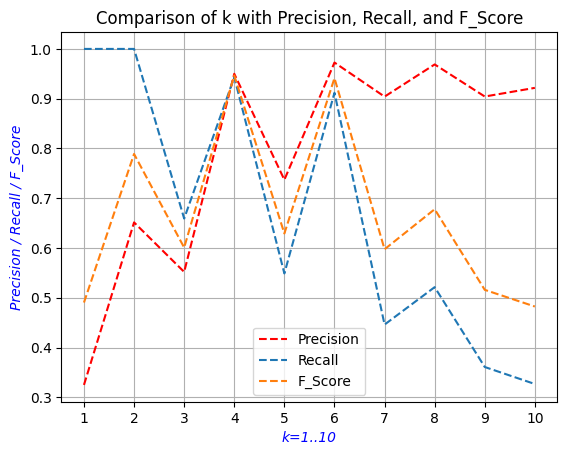

In [28]:
flow()

##<font color="red">(4).L2-normalisation feature, then using Manhattan Distance</font>

Please choose k-means clustering mode options (1-5) :

(1).Eucledian Distance
(2).L2-normalisation feature, then using Euclidean Distance
(3).Manhattan Distance
(4).L2-normalisation feature, then using Manhattan Distance
(5).Cosine Similarity Distance (a bit long(?) to wait...)
(0).exit()

Your choice:4
k= 1 precision= 0.32485729112610273 recall= 1.0 f_score= 0.49040344692518606 (after 1 iteration)
k= 2 precision= 0.6514047866805411 recall= 1.0 f_score= 0.7889098928796472 (after 5 iteration)
k= 3 precision= 0.5539280958721704 recall= 0.6645367412140575 f_score= 0.6042120551924473 (after 6 iteration)
k= 4 precision= 0.9636073241686156 recall= 0.9637722501141032 f_score= 0.9636897800849996 (after 5 iteration)
k= 5 precision= 0.7260883380997776 recall= 0.5214513920584208 f_score= 0.6069863195643511 (after 6 iteration)
k= 6 precision= 0.9517872796337781 recall= 0.5575079872204473 f_score= 0.7031480482101097 (after 9 iteration)
k= 7 precision= 0.6851800167457438 recall= 0.42018484710178 f_s

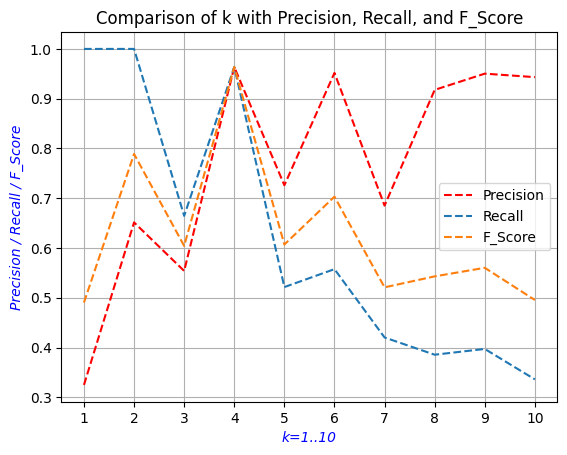

In [30]:
flow()

##<font color="red">(5).Cosine Similarity Distance (a bit long(?) to wait...)</font>

Please choose k-means clustering mode options (1-5) :

(1).Eucledian Distance
(2).L2-normalisation feature, then using Euclidean Distance
(3).Manhattan Distance
(4).L2-normalisation feature, then using Manhattan Distance
(5).Cosine Similarity Distance (a bit long(?) to wait...)
(0).exit()

Your choice:5
k= 1 precision= 0.32485729112610273 recall= 1.0 f_score= 0.49040344692518606 (after 49 iteration)
k= 2 precision= 0.6514047866805411 recall= 1.0 f_score= 0.7889098928796472 (after 49 iteration)
k= 3 precision= 0.5880441091120139 recall= 0.8670698311273392 f_score= 0.7008046480529362 (after 49 iteration)
k= 4 precision= 0.6659373190037969 recall= 0.59036969420356 f_score= 0.6258807874920616 (after 49 iteration)
k= 5 precision= 0.6171210788625037 recall= 0.4803742583295299 f_score= 0.5402284101116387 (after 49 iteration)
k= 6 precision= 0.5959252971137521 recall= 0.4205271565495208 f_score= 0.49309295247014745 (after 49 iteration)
k= 7 precision= 0.32485729112610273 recall= 1.0 f_score= 0

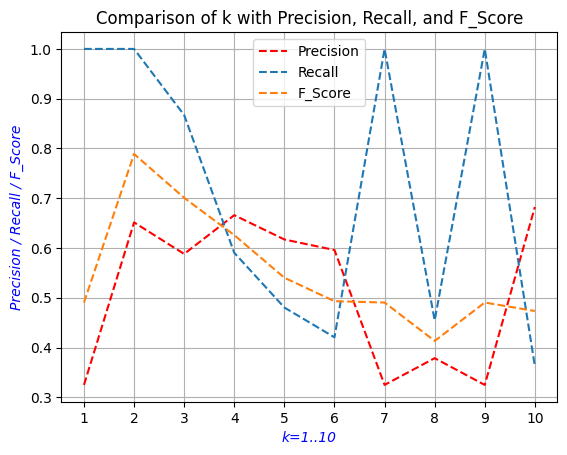

In [31]:
flow()